Author: K. Geil

Date: 03/2023

Description: 

Notes:

## Set up

In [1]:
import numpy as np
import glob

import rioxarray as rio
import xarray as xr

from natsort import natsorted 
import dask.array as da

import matplotlib.pyplot as plt

import pandas as pd


In [2]:
# notebook directory location
work_dir='/work/hpc/users/kerrie/UN_FAO/repos/pyAEZ_data_prep/' # orion

# data directory location
data_dir='/work/hpc/users/kerrie/UN_FAO/data/orig/DataDownload03152023/' # orion
srad_dir='/work/hpc/users/kerrie/UN_FAO/data/from_Gunther/' # orion

# output data file directory
out_dir='/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/'

# linux path of project directory (to include in file metadata)
source_dir='/gri/projects/rgmg/climate/UN_FAO/'

# input file name components
dataset='AgERA5'
experiment='Hist'
year='1980'
months=[str(x).rjust(2,'0') for x in np.arange(1,13)]
gridsize='5m'
file_ext_d='.pxv'
file_exts_m=['.rst','.rdc']
variables=['Precip','Srad','Tmax-2m','Tmin-2m','Vapr','Wind-10m','Elevation','Mask']

# some constants
# landfrac_thresh=2500
month_int=np.arange(1,13)

# metadata for output data files
timeattrs={'standard_name':'time','long_name':'time','axis':'T'}
time_encoding={'calendar':'standard','units':'days since 1900-01-01 00:00:00','_FillValue':None}
latattrs={'standard_name':'latitude','long_name':'latitude','units':'degrees_north','axis':'Y'}
lat_encoding={'_FillValue':None}
lonattrs={'standard_name':'longitude','long_name':'longitude','units':'degrees_east','axis':'X'}
lon_encoding={'_FillValue':None}
var_encoding = {'zlib':True,'dtype':'float32'}

In [3]:
# create middle of the month datetimes
# these will be assigned to the time dim of climate data
time_ms=pd.date_range(year+'-01-01',year+'-12-31',freq='MS')
time_me=pd.date_range(year+'-01-01',year+'-12-31',freq='M')+pd.Timedelta('1d')
offset=(time_me-time_ms)/2
time=time_me-offset
# time

## Define functions

In [4]:
# function for getting a list of data files
def getFilelist(var,ext):
    if (var=='Elevation'):
        filelist=[data_dir+'ALOSdem5m_fill.rst']
#     elif (var=='Mask'):
#         filelist=[data_dir+'ALOSmask5m_fill.rst']     
#         filelist=['/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/mask_2287408_5m.nc'] 
    elif (var=='Srad'):
        filename=var+'_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+ext
        filelist=natsorted(glob.glob(srad_dir+filename))
    else:
        filename=var+'_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+ext
        filelist=natsorted(glob.glob(data_dir+'Climate/monthly/'+filename))

    return filelist

In [5]:
# function to load data into xarray dataset
def loadData(filelist):
    if (len(filelist)>1):
        time_ms=pd.date_range(year+'-01-01',year+'-12-31',freq='MS')
        time_me=pd.date_range(year+'-01-01',year+'-12-31',freq='M')+pd.Timedelta('1d')
        offset=(time_me-time_ms)/2
        time=time_me-offset

        data=[]
        for t,f in zip(time,filelist):
            d=xr.open_dataset(f,engine='rasterio')
            d=d.rename({'band':'time'})
            d.coords['time']=[t]
            data.append(d)
        ds=xr.combine_by_coords(data) 
#         del ds.band
    else:
        if 'mask' in filelist[0]:
            ds=xr.open_dataset(filelist[0])
        else:
            ds=xr.open_dataset(filelist[0],engine='rasterio').squeeze() 
            del ds.coords['band']

    if 'y' in list(ds.coords): 
        ds['y']=ds['y'].astype('float32')
    if 'x' in list(ds.coords):
        ds['x']=ds['x'].astype('float32')        
    return ds

## Create binary admin mask


In [8]:
# use one of the monthly data files to create a mask because 
# the ALOS mask, daily dev file, and monthly files all have a different number of grids with data present

# filelist=getFilelist('Mask','.nc')

filename='Precip_'+dataset+'_'+experiment+'_'+year+'_01_'+gridsize+'.rst'
filelist=natsorted(glob.glob(data_dir+'Climate/monthly/'+filename))
ds=loadData(filelist)
ds



<xarray.Dataset>
Dimensions:      (x: 4320, y: 2160)
Coordinates:
  * x            (x) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 ...
Data variables:
    band_data    (y, x) float32 ...

In [ ]:
# make pretty and attach metadata

# get rid of singleton dim info
# del ds.coords['band']

vname='admin_mask'
# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':vname})
# ds=ds.rename({'band_data':'admin_mask'})
ds[vname]=ds[vname].astype('int32')

# variable/coordinate metadata
varattrs={'standard_name':'admin_mask','long_name':'mask','units':'unitless','description':'binary administrative mask'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownloads/2023-03-15_DataDownload/Climate/monthly/Precip_AgERA5_Hist_1980_01_5m.rst',
                    'source_code':source_dir+'repo_pyAEZ_data_prep/pyAEZ_data_prep/global/data_prep.ipynb'})

ds

In [8]:
mask=ds.mask

In [20]:
# maskg=xr.open_dataset('/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/mask_2287408_5m.nc')['mask']
# maskg

In [9]:
# save the spatial ref
spatial_ref=ds.spatial_ref

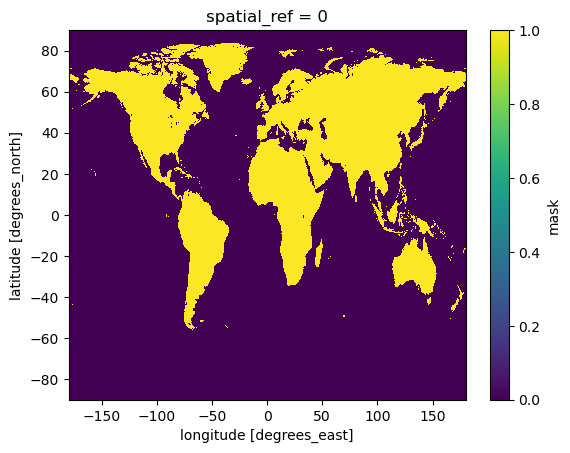

In [10]:
# # look at it
ds.mask.plot()

# fig=plt.figure(figsize=(20,6))
# ax=fig.add_subplot(121)
# ds.band_data.sel(y=slice(50,23),x=slice(-90,-65)).plot(ax=ax)
# ax=fig.add_subplot(122)
# ds.band_data.plot(ax=ax)

In [33]:
# # create binary mask, verify all 0,1, look at it
# # ds['band_data']=xr.where(ds.band_data>landfrac_thresh,1,0) # select only grids with land fraction over 25%
# ds['band_data']=xr.where(ds.band_data>0,1,0)
# ds['band_data']=xr.where(ds.band_data.y<-60,0,ds.band_data) # eliminate Antarctica
# print(np.unique(ds.band_data.data))
# print('ngrids with data',ds.band_data.sum().data)

# fig=plt.figure(figsize=(20,6))
# ax=fig.add_subplot(121)
# ds.band_data.sel(y=slice(50,23),x=slice(-90,-65)).plot(ax=ax)
# ax=fig.add_subplot(122)
# ds.band_data.plot(ax=ax)


In [216]:
# testpy=ds.rename({'x':'lon','y':'lat','band_data':'mask'})
# testg=xr.open_dataset('/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/mask_2287408_5m.nc')['mask']
# print('gaez has',testg.sum().data,'grids with data, pyaez has',testpy.mask.sum().data,'grids with data')

gaez has 2287408.0 grids with data, pyaez has 2242518 grids with data


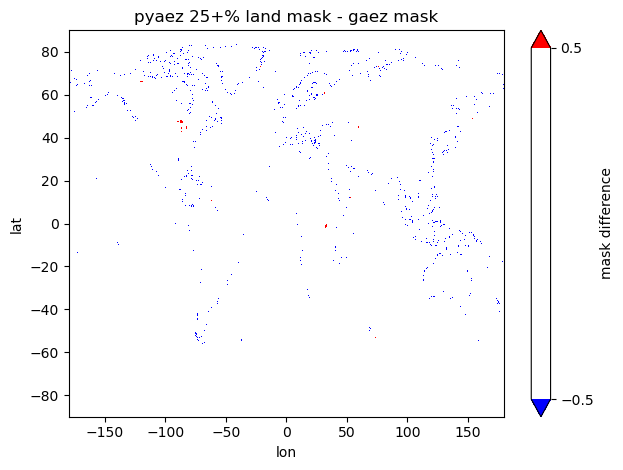

In [217]:
# # PYAEZ MASK MINUS GAEZ MASK
# # blue: gaez mask is 1, pyaez is not (mostly due to 25% land frac threshold)
# # white: both masks are 1 or both are 0
# # red: pyaez mask is 1, gaez is 0
# (testpy['mask']-testg).plot(colors=['blue','white','red'],levels=[-.5,.5],cbar_kwargs={'label':'mask difference'})
# plt.title('pyaez 25+% land mask - gaez mask')
# plt.tight_layout()

In [34]:
# # make pretty and attach metadata

# # get rid of singleton dim info
# # del ds.coords['band']

# vname='admin_mask'
# # rename variable and dimensions
# ds=ds.rename({'x':'lon','y':'lat','band_data':vname})
# # ds=ds.rename({'band_data':'admin_mask'})
# ds[vname]=ds[vname].astype('int32')

# # variable/coordinate metadata
# varattrs={'standard_name':'admin_mask','long_name':'mask','units':'unitless','description':'binary administrative mask'}
# ds[vname].attrs=varattrs
# ds['lat'].attrs=latattrs
# ds['lon'].attrs=lonattrs
# # ds['y'].attrs=latattrs
# # ds['x'].attrs=lonattrs

# # global attributes
# ds=ds.assign_attrs({'source_data':source_dir+'DataDownloads/2023-03-15_DataDownload/ALOSmask5m_fill.rst',
#                     'source_code':source_dir+'repo_pyAEZ_data_prep/pyAEZ_data_prep/global/data_prep.ipynb'})

# ds


In [223]:
# # write to file
# ds.to_netcdf(out_dir+'admin_mask_25pct_noantarctica_2242518.nc',
#             encoding={'lat':lat_encoding,
#                       'lon':lon_encoding,
#                       vname:{'zlib':True,'dtype':'int32'}})

# # write to file
# ds.to_netcdf(out_dir+'mask_2287408_5m.nc',
#             encoding={'lat':lat_encoding,
#                       'lon':lon_encoding,
#                       vname:{'zlib':True,'dtype':'int32'}})

# Output other variables to netcdf

In [35]:
# mask=xr.open_dataset(out_dir+'admin_mask_25pct_noantarctica_2242518.nc')['admin_mask']
# print(mask.sum().data)

# mask

10m Wind

In [11]:
vname='Wind-10m'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
ds=ds.where(mask>0)

# variable/coordinate metadata
varattrs={'standard_name':'Wind-10m',
          'long_name':'10m Wind Speed',
          'units':'m/s',
          'description':'monthly mean wind speed at 10m above surface'}
ds['Wind-10m'].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Wind-10m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/global/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Wind-10m     (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Wind...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/global/da...

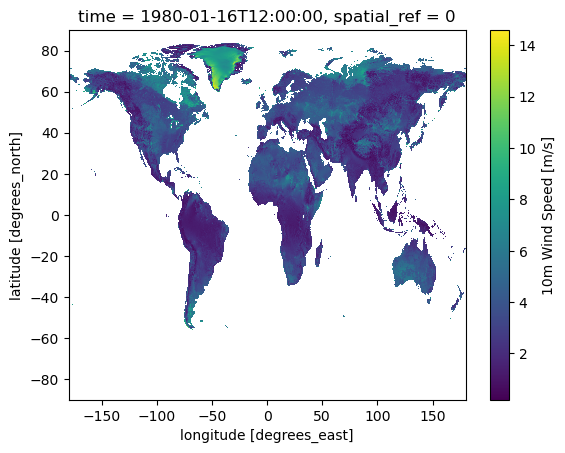

In [15]:
ds['Wind-10m'].sel(time='1980-01').plot()

In [12]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

# write new mask based on monthly files

In [17]:
# remove antarctica
grids=ds[vname][0,:,:].where(ds.lat>-60) 
grids=xr.where(np.isfinite(grids),1,0)

# further mask with gaez mask
grids=xr.where(mask>0,grids,np.nan) 
grids.sum().data # note it's less data points than the gaez daily dev files


array(2268708.)

In [18]:
# make pretty
grids=grids.fillna(0)
grids=grids.drop('time')
grids.name='mask'
grids['lat'].attrs=latattrs
grids['lon'].attrs=lonattrs
grids=grids.to_dataset()
grids['mask'].attrs={'description':'binary admin mask for monthly data created using ALOSmask5m_fill.rst, precip pxv file, and monthly wind rst file. Total grid cells containing data = 2268708.'}
grids=grids.assign_coords({'spatial_ref':spatial_ref})

grids

<xarray.Dataset>
Dimensions:      (lat: 2160, lon: 4320)
Coordinates:
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 0
Data variables:
    mask         (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [19]:
# write to file
grids.to_netcdf(out_dir+'mask_2268708_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'mask':{'zlib':True,'dtype':'int32'}})

/tmp/ipykernel_390751/2323925894.py:2: SerializationWarning: saving variable mask with floating point data as an integer dtype without any _FillValue to use for NaNs
  grids.to_netcdf(out_dir+'mask_2268708_5m.nc',


In [20]:
admin_mask=xr.open_dataset(out_dir+'mask_2268708_5m.nc')['mask']

Short wave radiation 

there something wrong going on with negative values/the -9999 missing value here

In [28]:
vname='Srad'

filelist=getFilelist(vname,'.tif')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
# ds=ds.where(mask>0)
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'surface short wave radiation down',
        'units':'J/m2/day',
        'description':'monthly mean downwelling shortwave radiation at the surface'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'data/from_Gunther/Srad_AgERA5_Hist_1980_*_5m.tif',
                    'source_code':source_dir+'pyAEZ_data_prep/global/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Srad         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/data/from_Gunther/Srad_Ag...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/global/da...

In [33]:
# test for negatives
test=ds[vname][0,:,:]
testneg=xr.where(test<0,1,0)
print(testneg.sum().data)

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

array(0)

In [34]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

Precip

In [70]:
# vname='Precip'

# filelist=getFilelist(vname,'.rst')
# ds=loadData(filelist)

# testpres=ds.band_data[0,:,:].where(ds.band_data.y>-60) # remove antarctica
# testpres=xr.where(np.isfinite(testpres),1,0) # how many grids are there in the raw rst without antarctica

# print(testpres.sum().data)

# # testneg=xr.where(ds.band_data[0,:,:]<0,1,0)
# # print(testneg.sum().data)
# # testneg.plot()

In [71]:
# maskg_xy=maskg.rename({'lat':'y','lon':'x'})
# maskg_xy.sum().data


In [72]:
# testpres=xr.where(maskg_xy>0,testpres,0) # further mask with gaez mask
# print(testpres.sum().data)


In [35]:
vname='Precip'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

ds=ds.where(ds.y>-60)
# ngrids=np.where(np.isfinite(ds.band_data[0,:,:]),1,0)
# print('grids with data in monthly precip file =',ngrids.sum())

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
# ds=ds.where(mask==1)
ds=ds.where(admin_mask>0)

# ngrids=np.where(np.isfinite(ds[vname][0,:,:]),1,0)
# print('grids with data after masking =',ngrids.sum())


# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'precipitation',
        'units':'mm/month',
        'description':'monthly total accumulated precipitation'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Precip_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/global/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Precip       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Prec...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/global/da...

In [37]:
# test for negatives
test=ds[vname][0,:,:]
testneg=xr.where(test<0,1,0)
print(testneg.sum().data)

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

0
2268708


In [38]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

Tmin-2m

In [39]:
vname='Tmin-2m'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
# ds=ds.where(mask==1)
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'2m minimum surface air temperature',
        'units':'degrees C',
        'description':'monthly mean minimum surface air temperature at 2m'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Tmin-2m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/global/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Tmin-2m      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Tmin...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/global/da...

In [41]:
# test for negatives
# not needed here

# test for correct mask
test=ds[vname][0,:,:]
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

2268708


In [42]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

Tmax-2m

In [43]:
vname='Tmax-2m'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
# ds=ds.where(mask==1)
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'2m maximum surface air temperature',
        'units':'degrees C',
        'description':'monthly mean maximum surface air temperature at 2m'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Tmax-2m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/global/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Tmax-2m      (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Tmax...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/global/da...

In [44]:
# test for negatives
# not needed here

# test for correct mask
test=ds[vname][0,:,:]
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

2268708


In [45]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

Vapor pressure

In [46]:
vname='Vapr'

filelist=getFilelist(vname,'.rst')
ds=loadData(filelist)

# fix the spatial_ref, we don't want it as an array
del ds['spatial_ref']
ds=ds.assign_coords({'spatial_ref':spatial_ref})

ds=ds.rename({'x':'lon','y':'lat','band_data':vname})

# apply mask 
# ds=ds.where(mask==1)
ds=ds.where(admin_mask>0)

# variable/coordinate metadata
varattrs={'standard_name':vname,
        'long_name':'vapor pressure',
        'units':'hPa',
        'description':'monthly mean vapor pressure'}
ds[vname].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Vapr_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/global/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lat: 2160, lon: 4320)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 0
Data variables:
    Vapr         (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Vapr...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/global/da...

In [47]:
# test for negatives
test=ds[vname][0,:,:]
testneg=xr.where(test<0,1,0)
print(testneg.sum().data)

# test for correct mask
ngrids=xr.where(np.isfinite(test),1,0)
print(ngrids.sum().data)

0
2268708


In [80]:
# write to file
ds.to_netcdf(out_dir+vname+'_monthly_1980_5m.nc',
            encoding={'lat':lat_encoding,
                      'lon':lon_encoding,
                      'time':time_encoding,
                      vname:var_encoding})

# Check netcdf files

double checking that all files have 2268708 grids with data

In [48]:
files=natsorted(glob.glob(out_dir+'*_monthly_'+year+'_5m.nc'))
files


['/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Precip_monthly_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Srad_monthly_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Tmax-2m_monthly_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Tmin-2m_monthly_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Vapr_monthly_1980_5m.nc',
 '/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Wind-10m_monthly_1980_5m.nc']

In [49]:
for f in files:
    d=xr.open_dataset(f) # read a data file
    vn=list(d.keys())[0]  # get variable name
    d=xr.where(np.isfinite(d[vn].isel(time=0)),1,0)  # select one timestep and create mask
    print(vn,'has',d.sum().data,'with data')  # count how many grids have data

Precip has 2268708 with data
Srad has 2268708 with data
Tmax-2m has 2268708 with data
Tmin-2m has 2268708 with data
Vapr has 2268708 with data
Wind-10m has 2268708 with data


# difference between 

where gaez daily dev files have data

and

where pyaez monthly files have data

In [51]:
ddfile='/work/hpc/users/kerrie/UN_FAO/data/gaez_nc_files/global_1980/dailydev/Precip_DailyDev_1980_5m.nc'
mfile='/work/hpc/users/kerrie/UN_FAO/data/pyaez_nc_files/global_1980/monthly/Precip_monthly_1980_5m.nc'


In [55]:
dd_var=xr.open_dataset(ddfile)['Precip'].isel(time=0).drop('time')
dd_var

<xarray.DataArray 'Precip' (lat: 2160, lon: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
    spatial_ref  int64 ...
Attributes:
    standard_name:  Precip
    long_name:      precipitation
    units:          mm/day

In [56]:
m_var=xr.open_dataset(mfile)['Precip'].isel(time=0).drop('time')
# m_var.name="Precip"
# m_var=m_var.where(m_var.lat>-60.)
m_var

<xarray.DataArray 'Precip' (lat: 2160, lon: 4320)>
[9331200 values with dtype=float32]
Coordinates:
  * lon          (lon) float32 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float32 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
    spatial_ref  int64 ...
Attributes:
    standard_name:  Precip
    long_name:      precipitation
    units:          mm/month
    description:    monthly total accumulated precipitation

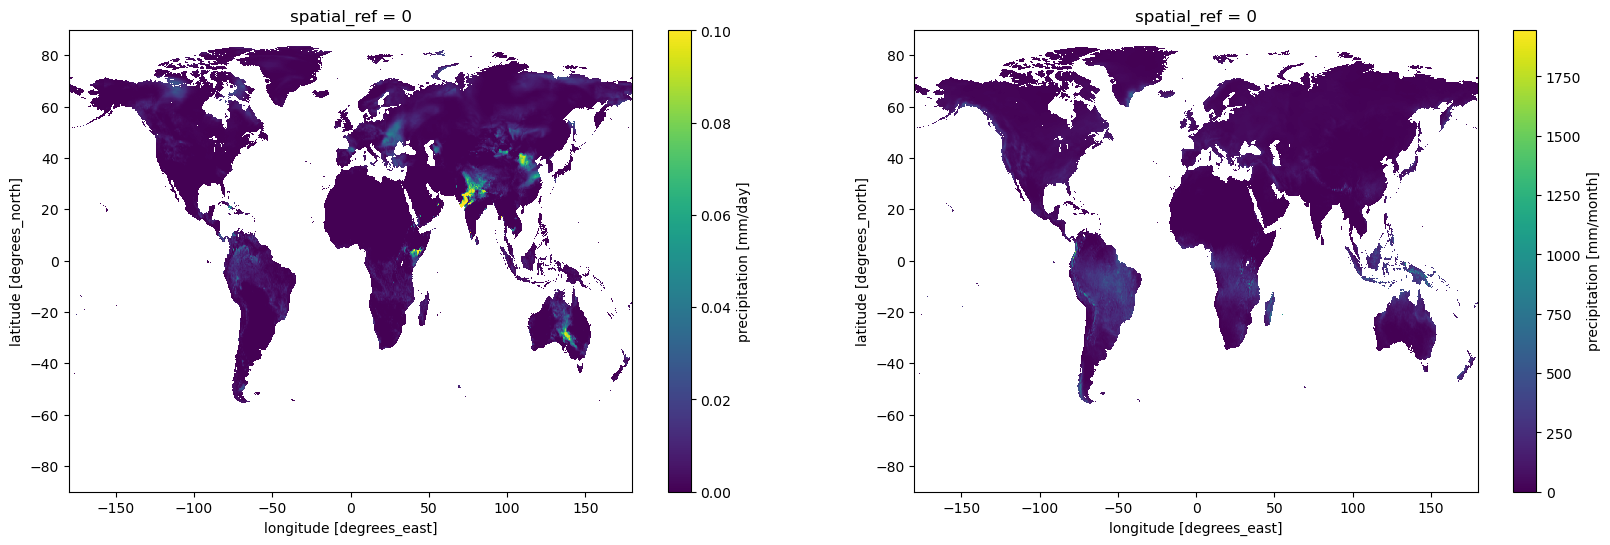

In [57]:
fig=plt.figure(figsize=(20,6))
ax=fig.add_subplot(121)
dd_var.plot(ax=ax)
ax=fig.add_subplot(122)
m_var.plot(ax=ax)

In [58]:
dd_mask=xr.where(np.isfinite(dd_var),1,0)
m_mask=xr.where(np.isfinite(m_var),1,0)
dd_mask.data.sum(),m_mask.data.sum()

(2287408, 2268708)

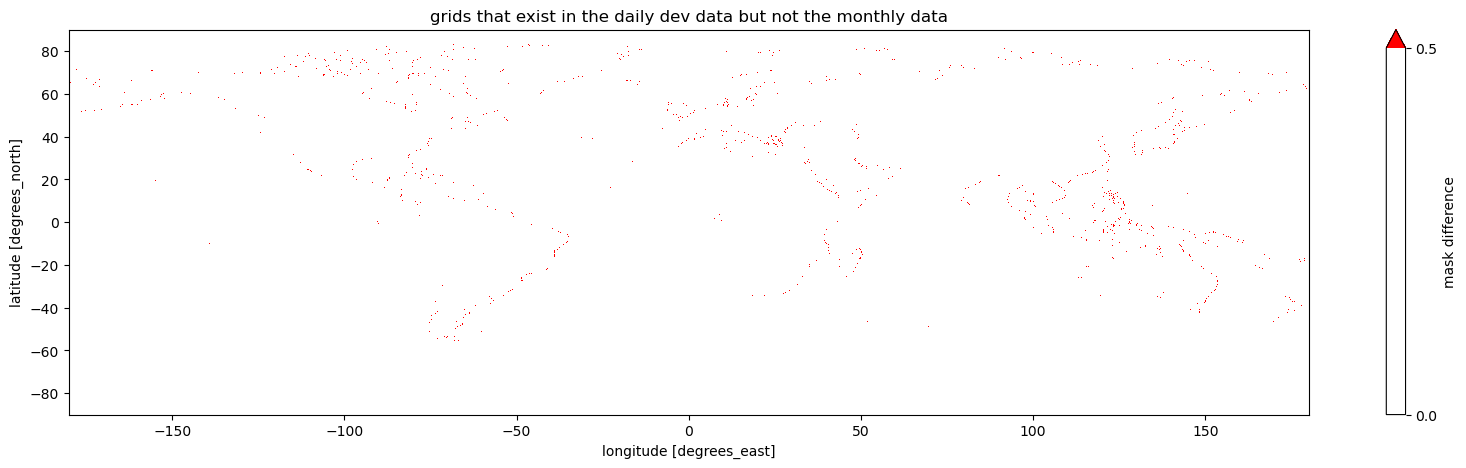

In [61]:
fig=plt.figure(figsize=(20,5))
ax=fig.add_subplot(111)
(dd_mask-m_mask).plot(colors=['white','red'],levels=[0,.5],cbar_kwargs={'label':'mask difference'})
plt.title('grids that exist in the daily dev data but not the monthly data')
plt.show()
# ax=fig.add_subplot(131)
# testg.plot(ax=ax)#.sel(lat=slice(45,15),lon=slice(-90,-60)).plot(ax=ax)
# ax=fig.add_subplot(132)
# testm.plot(ax=ax)#.sel(lat=slice(45,15),lon=slice(-90,-60)).plot(ax=ax)
# ax=fig.add_subplot(133)
# # red: grids where the gaez daily dev has data but the monthly data is missing
# (testg-testm).plot(colors=['white','red'],levels=[0,.5],cbar_kwargs={'label':'mask difference'})

## Compute 2m wind

In [11]:
# load the data
filelist=getFilelist('Wind-10m','.rst')
ds=loadData(filelist)
ds

<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float32 nan nan nan nan ... 3.911 3.911 3.911

In [12]:
# interpolate 10m wind to 2m wind
height=10
z_adjust=4.87/(np.log(67.8*height-5.42))
print(z_adjust)
ds_2m=ds*z_adjust
ds_2m

0.7479510751679441


<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float32 nan nan nan nan ... 2.925 2.926 2.926

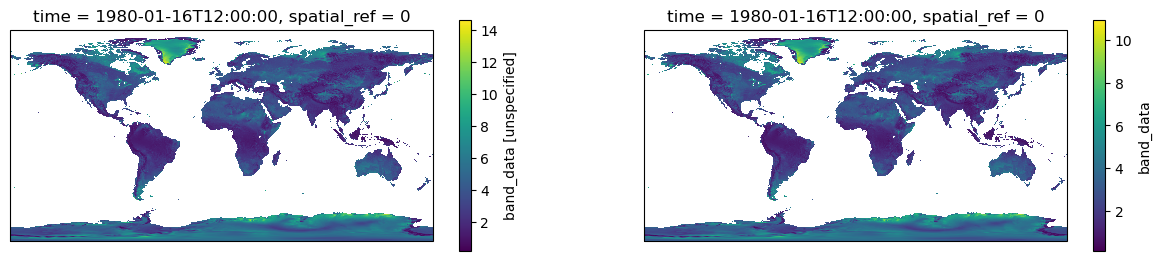

In [13]:
# visualize
fig=plt.figure(figsize=(15,3))
ax=fig.add_subplot(121,projection=ccrs.PlateCarree())
ds.band_data[0,:,:].plot(ax=ax)
ax=fig.add_subplot(122,projection=ccrs.PlateCarree())
ds_2m.band_data[0,:,:].plot(ax=ax)
plt.show()

In [14]:
# make pretty and attach metadata
ds=ds_2m.copy()

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':'wind_speed'})

# variable/coordinate metadata
varattrs={'standard_name':'wind_speed','long_name':'2m Wind Speed','units':'m s-1','description':'wind speed at 2m above surface'}
ds['wind_speed'].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Wind-10m_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lon: 4320, lat: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    wind_speed   (time, lat, lon) float32 nan nan nan nan ... 2.925 2.926 2.926
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Wind...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/data_prep...

In [15]:
# write to file
ds.to_netcdf(out_dir+'wind_speed_monthly_'+year+'.nc',mode='w',format='NETCDF4',unlimited_dims='time',
            encoding={'time':time_encoding,'lat':lat_encoding,'lon':lon_encoding})

## Convert radiation units

In [16]:
# set constants
# var='SRad'
# file_ext='.rst'
# filename=var+'_'+dataset+'_'+experiment+'_'+year+'_*_'+gridsize+file_ext
# filelist=natsorted(glob.glob(data_dir+'Climate/monthly/'+filename))
# month_int=np.arange(1,13)

# load the data
filelist=getFilelist('SRad','.rst')
ds=loadData(filelist)
print(ds.band_data.min().data,ds.band_data.max().data)
ds

-9928.06 40414590.0


<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float32 nan nan nan ... 3.806e+07 3.806e+07

The rds metadata file doesn't have a lot of info on what this is. I'm assuming it's average monthly *incoming* solar radiation *at the surface*. In which case there should be no negative values.

Let's look at where this data is negative

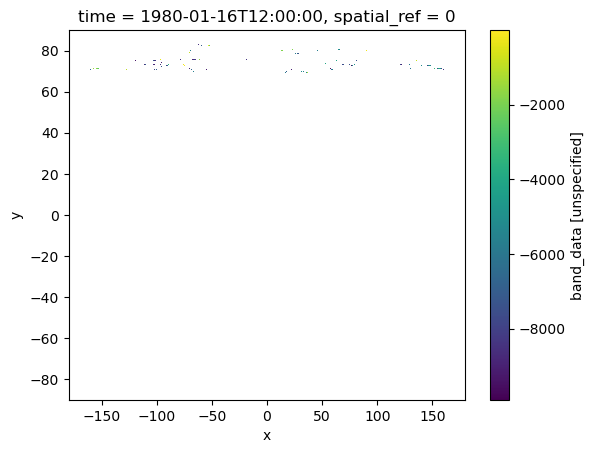

In [17]:
dplot=ds.band_data[0,:,:]
dplot=dplot.where(dplot<0)
dplot.plot()

ok so weird stuff going on at high latitudes. We'll set negatives equal to 0

In [18]:
ds=xr.where(ds<0,0,ds)
print(ds.band_data.min().data,ds.band_data.max().data)

0.0 40414590.0


In [19]:
# Convert J/m2/day to W/m2
s_per_day=86400
ds_Wm2=ds/s_per_day
print(ds_Wm2.band_data.min().data,ds_Wm2.band_data.max().data)
ds_Wm2

0.0 467.7614814814815


<xarray.Dataset>
Dimensions:      (time: 12, x: 4320, y: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * x            (x) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * y            (y) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    band_data    (time, y, x) float64 nan nan nan nan ... 440.5 440.5 440.5

In [20]:
# make pretty and attach metadata
ds=ds_Wm2.copy()

# rename variable and dimensions
ds=ds.rename({'x':'lon','y':'lat','band_data':'short_rad'})

# variable/coordinate metadata
varattrs={'standard_name':'short_rad',
        'long_name':'surf short wave rad down',
        'units':'W m-2',
        'description':'downwelling shortwave radiation at the surface'}
ds['short_rad'].attrs=varattrs
ds['lat'].attrs=latattrs
ds['lon'].attrs=lonattrs
ds['time'].attrs=timeattrs

# global attributes
ds=ds.assign_attrs({'source_data':source_dir+'DataDownload03152023/Srad_AgERA5_Hist_1980_*_5m.rst',
                    'source_code':source_dir+'pyAEZ_data_prep/data_prep.ipynb'})

ds

<xarray.Dataset>
Dimensions:      (time: 12, lon: 4320, lat: 2160)
Coordinates:
  * time         (time) datetime64[ns] 1980-01-16T12:00:00 ... 1980-12-16T12:...
  * lon          (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat          (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.87 -89.96
    spatial_ref  int32 0
Data variables:
    short_rad    (time, lat, lon) float64 nan nan nan nan ... 440.5 440.5 440.5
Attributes:
    source_data:  /gri/projects/rgmg/climate/UN_FAO/DataDownload03152023/Srad...
    source_code:  /gri/projects/rgmg/climate/UN_FAO/pyAEZ_data_prep/data_prep...

In [21]:
# write to file
ds.to_netcdf(out_dir+'short_rad_monthly_'+year+'.nc',mode='w',format='NETCDF4',unlimited_dims='time',
            encoding={'time':time_encoding,'lat':lat_encoding,'lon':lon_encoding})

## Create relative humidity

In [22]:
# load data
file_ext='.rst'
var='Tmin-2m'
filelist=getFilelist(var,file_ext)
Tmin=loadData(filelist).band_data

var='Tmax-2m'
filelist=getFilelist(var,file_ext)
Tmax=loadData(filelist).band_data

var='Vapr'
filelist=getFilelist(var,file_ext)
Vapr=loadData(filelist).band_data

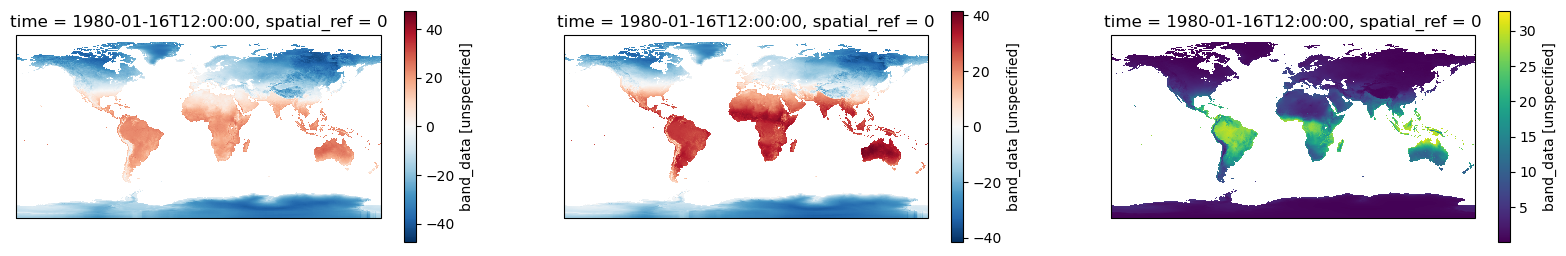

In [24]:
# visualize
fig=plt.figure(figsize=(20,3))
ax=fig.add_subplot(131,projection=ccrs.PlateCarree())
Tmin[0,:,:].plot(ax=ax)
ax=fig.add_subplot(132,projection=ccrs.PlateCarree())
Tmax[0,:,:].plot(ax=ax)
ax=fig.add_subplot(133,projection=ccrs.PlateCarree())
Vapr[0,:,:].plot(ax=ax)
plt.show()

In [ ]:
# convert units 
# vapor pressure hPa to kPa
Vapr=0.1*Vapr



Actually we need to compute RH on daily data and then average to monthly. Come back to this when you get the daily data